In [79]:
from net import Net
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [80]:
model = Net(learnable=True)
model.build(input_shape=(None, 512, 512, 1))

In [81]:
model.summary()

Model: "net_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
net_block_60 (NetBlock)      multiple                  9120      
_________________________________________________________________
net_block_61 (NetBlock)      multiple                  40448     
_________________________________________________________________
net_block_62 (NetBlock)      multiple                  94464     
_________________________________________________________________
net_block_63 (NetBlock)      multiple                  171008    
_________________________________________________________________
net_block_64 (NetBlock)      multiple                  110000    
_________________________________________________________________
global_average_pooling2d_12  multiple                  0         
_________________________________________________________________
dense_12 (Dense)             multiple                  162  

In [82]:
PATH = 'storage/TBX11K'
imgs = PATH + '/imgs'
trainval = PATH + '/lists/TBX11K_trainval.txt'

In [87]:
filenames = None
req_filenames = []
categories = []

with open(trainval) as f:
    filenames = [i.strip() for i in f.readlines()]

for filename in filenames:
    if filename.startswith('tb'):
        categories.append('tb')
        req_filenames.append(filename)
    elif filename.startswith('health'):
        categories.append('health')
        req_filenames.append(filename)
    else:
        continue

req_filenames = req_filenames[:1600]
categories = categories[:1600]
        
df = pd.DataFrame({
    'filename': req_filenames,
    'category': categories
    })

df = df.sample(frac=1)

In [89]:
df.head()

,filename,category
602,tb/tb0905.png,tb
296,tb/tb0450.png,tb
626,tb/tb0942.png,tb
677,tb/tb1017.png,tb
1363,health/h0733.png,health


In [90]:
df['category'].value_counts()

health    800
tb        800
Name: category, dtype: int64

In [102]:
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [103]:
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    rescale=1.0/255.0,
    horizontal_flip=True)

validate_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    rescale=1.0/255.0,
    horizontal_flip=True)

validate_generator = validate_datagen.flow_from_dataframe(
    validate_df, 
    imgs,
    x_col = 'filename',
    y_col = 'category',
    target_size=(512, 512),
    class_mode='categorical',
    batch_size=15
    )

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    imgs,
    x_col = 'filename',
    y_col = 'category',
    target_size = (512, 512),
    class_mode='categorical',
    batch_size=15
    )

Found 320 validated image filenames belonging to 2 classes.
Found 1280 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


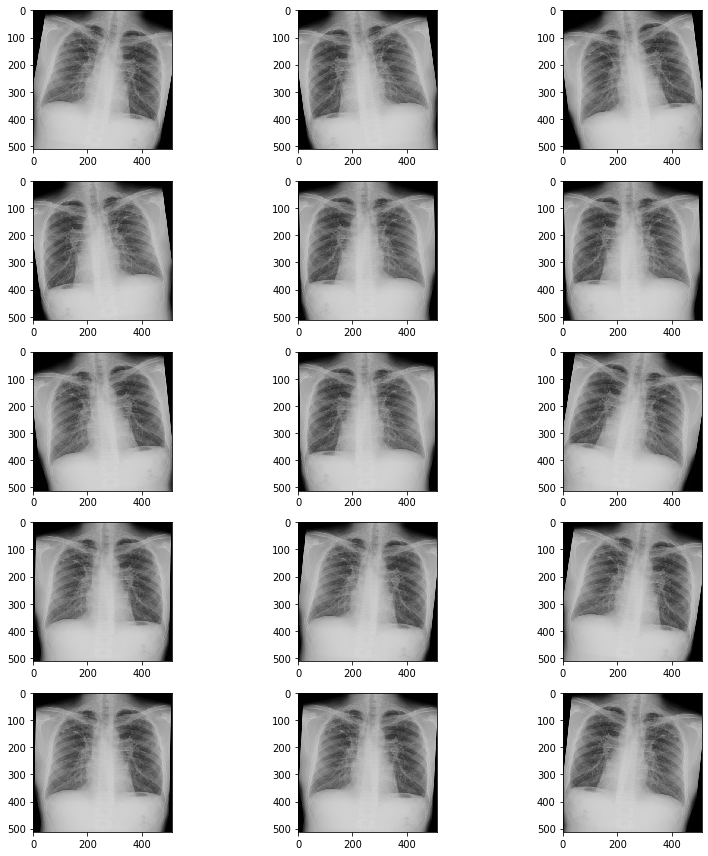

In [104]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    imgs,
    x_col='filename',
    y_col='category',
    target_size=(512, 512),
    class_mode='categorical'
    )

plt.figure(figsize=(12, 12))
for i in range(15):
    plt.subplot(5, 3, i+1)
    for x, y in example_generator:
        image = x[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [121]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 32
epochs=50

In [122]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [123]:
model = Net(learnable=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [124]:
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data = validate_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks = callbacks
    )

Epoch 1/50
40/40 [==============================] - 46s 1s/step - loss: 0.4293 - accuracy: 0.7583 - val_loss: 0.7348 - val_accuracy: 0.5400
Epoch 2/50
40/40 [==============================] - 37s 925ms/step - loss: 0.3377 - accuracy: 0.8249 - val_loss: 1.9220 - val_accuracy: 0.4867
Epoch 3/50
10/40 [======>.......................] - ETA: 28s - loss: 2.0254 - accuracy: 0.4867
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
40/40 [==============================] - 41s 1s/step - loss: 0.2343 - accuracy: 0.9266 - val_loss: 2.0254 - val_accuracy: 0.4867
Epoch 4/50
40/40 [==============================] - 37s 913ms/step - loss: 0.2425 - accuracy: 0.8957 - val_loss: 2.0167 - val_accuracy: 0.5467
Epoch 5/50
40/40 [==============================] - 37s 933ms/step - loss: 0.1732 - accuracy: 0.9451 - val_loss: 0.8301 - val_accuracy: 0.6467
Epoch 6/50
40/40 [==============================] - 36s 905ms/step - loss: 0.1875 - accuracy: 0.9391 - val_loss: 1.5805 - val_a

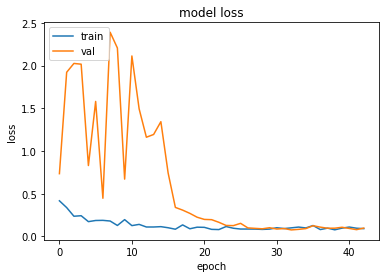

In [127]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [126]:
model.save('storage/first_model')

W1211 16:46:47.410034 140288031700800 save.py:168] Skipping full serialization of Keras layer <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9572c2e7f0>, because it is not built.
W1211 16:46:52.908767 140288031700800 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1784: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


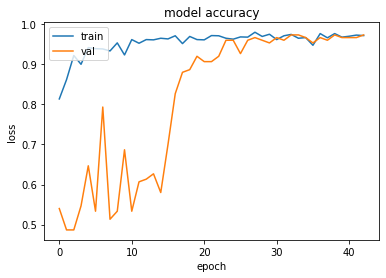

In [128]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()